In [48]:
import pandas as pd
import pymongo
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.functions import lower, regexp_replace
from nltk.tokenize import word_tokenize


from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, FloatType, DoubleType

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import ARIMA



In [3]:
df = pd.read_csv("Tweets.csv")

In [4]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
df = df.iloc[:, 1:]

df.columns = ["id", "date", "flag", "user", "text"]

#df.to_csv("Ready_Tweets.csv", index=False)

In [6]:
df.head()

,id,date,flag,user,text
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [7]:
df['date'].head()

0    Mon Apr 06 22:19:49 PDT 2009
1    Mon Apr 06 22:19:53 PDT 2009
2    Mon Apr 06 22:19:57 PDT 2009
3    Mon Apr 06 22:19:57 PDT 2009
4    Mon Apr 06 22:20:00 PDT 2009
Name: date, dtype: object

In [8]:
# Remove 'PDT' from the 'date' column
df['date'] = df['date'].str.replace('PDT', '', regex=False)


In [9]:
df

,id,date,flag,user,text
0,1467810672,Mon Apr 06 22:19:49 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,Mon Apr 06 22:19:53 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,Mon Apr 06 22:19:57 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,Mon Apr 06 22:19:57 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,Mon Apr 06 22:20:00 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...
1599994,2193601966,Tue Jun 16 08:40:49 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,2193601969,Tue Jun 16 08:40:49 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,2193601991,Tue Jun 16 08:40:49 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,2193602064,Tue Jun 16 08:40:49 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


# Sentiment Analysis with TextBlob and Vader using Pyspark and MongoDB

In [10]:
# Create a Spark session
spark = SparkSession.builder.appName("TwitterSentimentAnalysis").getOrCreate()


23/10/22 14:26:57 WARN Utils: Your hostname, College resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/10/22 14:26:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/22 14:26:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [11]:
# Define the schema for your data
schema = StructType([
    StructField("index", IntegerType(), True),
    StructField("id", IntegerType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True)
])

# Load the CSV data into a DataFrame
tweets_df = spark.read.csv("Tweets.csv", header=True, schema=schema)


In [12]:
# Create a temporary table for your DataFrame
tweets_df.createOrReplaceTempView("tweets")

In [13]:
# Example: Select top 10 tweets
top_10_tweets = spark.sql("SELECT * FROM tweets LIMIT 10")
top_10_tweets.show()

23/10/22 14:27:14 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 0, 1467810369, Mon Apr 06 22:19:45 PDT 2009, NO_QUERY, _TheSpecialOne_, @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: index, id, date, flag, user, text
Expected: index but found: 0
CSV file: file:///home/muhammad/Downloads/Tweets.csv


+-----+----------+--------------------+--------+---------------+--------------------+
|index|        id|                date|    flag|           user|                text|
+-----+----------+--------------------+--------+---------------+--------------------+
|    1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|    2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|    3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|    4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|    5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|    6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|    7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|    8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|    9|1467812025|Mon Apr 06 22:20:...|NO_QUERY|      

In [14]:
total_rows = tweets_df.count()
print("Total rows in the dataset:", total_rows)

Total rows in the dataset: 1599999


In [15]:
tweets_df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



In [16]:
# Text preprocessing
tweets_df = tweets_df.withColumn("text", lower(tweets_df["text"]))
tweets_df = tweets_df.withColumn("text", regexp_replace(tweets_df["text"], "[^a-zA-Z\\s]", ""))

In [19]:
# Define a UDF to perform sentiment analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

sentiment_udf = udf(get_sentiment, DoubleType())
tweets_df = tweets_df.withColumn("sentiment", sentiment_udf(tweets_df["text"]))

# Show the results
tweets_df.select("text", "sentiment").show()

23/10/22 14:28:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+--------------------+--------------------+
|                text|           sentiment|
+--------------------+--------------------+
|is upset that he ...|                 0.0|
|kenichan i dived ...|                 0.5|
|my whole body fee...|                 0.2|
|nationwideclass n...|              -0.625|
|kwesidei not the ...|                 0.2|
|         need a hug |                 0.0|
|loltrish hey  lon...|  0.2733333333333333|
|tatianak nope the...|                 0.0|
|twittera que me m...|                 0.0|
|spring break in p...|-0.21428571428571427|
|i just repierced ...|                 0.0|
|caregiving i coul...|                 0.0|
|octolinz it it co...|                 0.0|
|smarrison i would...|               0.075|
|iamjazzyfizzle i ...|                 0.0|
|hollis death scen...|                 0.0|
|about to file taxes |                 0.0|
|lettya ahh ive al...|                 0.5|
|fakerpattypattz o...|                 0.0|
|alydesigns i was ...|          

In [41]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/muhammad/nltk_data...


True

In [20]:
# Initialize the NLTK SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Define a User Defined Function (UDF) to perform sentiment analysis
def analyze_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    if sentiment['compound'] >= 0.05:
        return "Positive"
    elif sentiment['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

sentiment_udf = udf(analyze_sentiment, StringType())

# Add a new column 'sentiment' to the DataFrame
tweets_df = tweets_df.withColumn("sentiment", sentiment_udf(tweets_df["text"]))

# Show the results
tweets_df.select("text", "sentiment").show()


23/10/22 14:28:14 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|is upset that he ...| Negative|
|kenichan i dived ...| Positive|
|my whole body fee...| Negative|
|nationwideclass n...| Negative|
|kwesidei not the ...|  Neutral|
|         need a hug | Positive|
|loltrish hey  lon...| Positive|
|tatianak nope the...|  Neutral|
|twittera que me m...|  Neutral|
|spring break in p...|  Neutral|
|i just repierced ...|  Neutral|
|caregiving i coul...| Negative|
|octolinz it it co...| Negative|
|smarrison i would...| Positive|
|iamjazzyfizzle i ...| Positive|
|hollis death scen...| Negative|
|about to file taxes |  Neutral|
|lettya ahh ive al...| Positive|
|fakerpattypattz o...| Positive|
|alydesigns i was ...|  Neutral|
+--------------------+---------+
only showing top 20 rows



In [21]:
# Initialize a connection to MongoDB (adjust the connection string as needed)
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["twitter_data"]
collection = db["tweets"]

In [22]:
data = df

In [23]:
# Convert the DataFrame to a list of dictionaries for insertion into MongoDB
tweets = data.to_dict(orient="records")

In [24]:
tweets[0]

{'id': 1467810672,
 'date': 'Mon Apr 06 22:19:49  2009',
 'flag': 'NO_QUERY',
 'user': 'scotthamilton',
 'text': "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"}

In [25]:
total_tweets = len(tweets)
print("Total rows in the dataset:", total_tweets)

Total rows in the dataset: 1599999


In [ ]:
# Insert the data into the MongoDB collection
collection.insert_many(tweets)

In [27]:
# Retrieve the data from the MongoDB collection
data = list(collection.find_one())

In [36]:
# Analyze sentiment for each tweet
for tweet in tweets:
    text = tweet["text"]
    analysis = TextBlob(text)
    tweet["sentiment_polarity"] = analysis.sentiment.polarity
    tweet["sentiment_subjectivity"] = analysis.sentiment.subjectivity


In [39]:
for tweet in tweets:
    collection.update_one(
        {"id": tweet["id"]},  # Use a unique identifier (e.g., "_id" field)
        {"$set": {"sentiment_polarity": tweet["sentiment_polarity"], "sentiment_subjectivity": tweet["sentiment_subjectivity"]}}
    )


In [1]:
# Retrieve a few updated results
results = list(collection.find().limit(5))  # Adjust the limit as needed

# Display the updated results
for result in results:
    print(f"Tweet: {result['text']}")
    print(f"Sentiment Polarity: {result['sentiment_polarity']}")
    print(f"Sentiment Subjectivity: {result['sentiment_subjectivity']}")
    print("--------------")

NameError: name 'collection' is not defined

# Time Series Analysis

In [41]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
#from fbprophet import Prophet
import matplotlib.pyplot as plt

In [42]:
# Create a DataFrame from the list of dictionaries
new_df = pd.DataFrame(tweets)

In [43]:
new_df

,id,date,flag,user,text,sentiment_polarity,sentiment_subjectivity
0,1467810672,Mon Apr 06 22:19:49 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0.000,0.0000
1,1467810917,Mon Apr 06 22:19:53 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0.500,0.5000
2,1467811184,Mon Apr 06 22:19:57 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0.200,0.4000
3,1467811193,Mon Apr 06 22:19:57 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",-0.625,1.0000
4,1467811372,Mon Apr 06 22:20:00 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,0.200,0.4000
...,...,...,...,...,...,...,...
1599994,2193601966,Tue Jun 16 08:40:49 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,1.000,0.3000
1599995,2193601969,Tue Jun 16 08:40:49 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,0.290,0.5225
1599996,2193601991,Tue Jun 16 08:40:49 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,0.200,0.5000
1599997,2193602064,Tue Jun 16 08:40:49 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,1.000,1.0000


In [44]:
# Assuming "date" is in datetime format, set it as the DataFrame's index
new_df['date'] = pd.to_datetime(new_df['date'])
new_df.set_index('date', inplace=True)

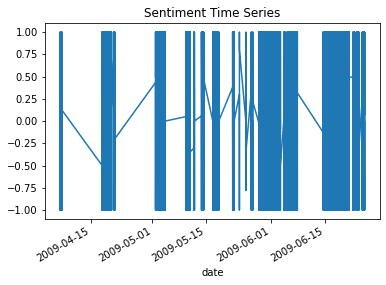

In [45]:
# Create a time series plot to visualize the sentiment data
new_df['sentiment_polarity'].plot(title='Sentiment Time Series')
plt.show()

In [46]:
# Define a function to evaluate a time series forecasting model
def evaluate_model(model, name):
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=10)  # Forecast the next 10 time points
    print(f"{name} Forecast: {forecast}")

In [ ]:
# ARIMA Model
arima_model = ARIMA(new_df['sentiment_polarity'], order=(5,1,0))  # Example ARIMA order
evaluate_model(arima_model, 'ARIMA')

/home/muhammad/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/muhammad/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/muhammad/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/muhammad/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/h

In [ ]:
# Exponential Smoothing Model
model_exponential = ExponentialSmoothing(train, seasonal='add', seasonal_periods=7)
model_exponential_fit = model_exponential.fit()
exponential_forecast = model_exponential_fit.forecast(steps=len(test))

In [ ]:
# Prophet Model
model_prophet = Prophet()
df_prophet = train.reset_index()
df_prophet.columns = ['ds', 'y']
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=len(test))
prophet_forecast = model_prophet.predict(future)

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='dashed')
plt.plot(test.index, exponential_forecast, label='Exponential Smoothing Forecast', linestyle='dashed')
plt.plot(test.index, prophet_forecast['yhat'][-30:], label='Prophet Forecast', linestyle='dashed')
plt.legend()
plt.show()


In [ ]:
# Close the MongoDB connection
client.close()

In [6]:
spark.stop()